# Global ms diagnosis on main combination GPS+ARGOS

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import os
from glob import glob

import matplotlib.pyplot as plt

import histlib.matchup as match
from  histlib.diagnosis import global_ms_drifter_sat_year, compute_sum_ms, nMSRe_id, C_x, true_err_x, plot_true_err_cor_part, plot_cor_uncor_part
from histlib.cstes import labels, zarr_dir, matchup_dir, var, c0, c1
from histlib.matchup import _data_var, _stress_var, _aviso_var

/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


In [2]:
def put_fig_letter(ax, letter):
    import matplotlib.transforms as mtransforms
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, letter+')', transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

In [3]:
DL =25*1e3 #meters
DT = 1800.0 #seconds
id_aviso = 'aviso__25__adt__es_cstrio_z15__alti_x'
id_co = 'co__25__adt_filtered_ocean_tide_internal_tide__es_cstrio_z15__drifter_x'

id_co_dic =  {'acc':'drifter_acc_x_25','coriolis':'drifter_coriolis_x_25','ggrad':'alti_ggx_adt_filtered_ocean_tide_internal_tide','wind':'es_cstrio_z15_drifter_wd_x'}
id_aviso_dic =  {'acc':'drifter_acc_x_25','coriolis':'drifter_coriolis_x_25','ggrad':'aviso_alti_ggx_adt','wind':'es_cstrio_z15_alti_wd_x'}

In [4]:
dt=3600#h
x2 = 10**2
u2 = x2/(2*dt**2)
#a2 = u2/(2*dt**2)
a2 = 6*x2/(dt**4)

# Datasets 

In [6]:
dsms = xr.open_dataset(os.path.join(zarr_dir+'_ok','global',f'ms_{int(DL//1000)}_{DT}_drogued.zarr'))
dsmean = xr.open_dataset(os.path.join(zarr_dir+'_ok','global',f'mean_{int(DL//1000)}_{DT}_drogued.zarr'))

ds, mslow, msup = global_ms_drifter_sat_year(dsmean, dsms, alpha=0.01)
mserr = (msup-mslow)/2

<xarray.DataArray 'nb_coloc' ()>
array(237860)


______________________
# Closure efficiancy : residdual S $\langle S^2 \rangle$ and $nS = \frac{\langle S^2 \rangle}{\sum_i \langle a_i^2 \rangle}$
- AVISO more efficient

In [7]:
print('Along-track')
print('MSRe = ' + f"{ds['sum_'+id_co].values,mserr['sum_'+id_co].values }")
print(f"nMSRe = {nMSRe_id(ds,mserr, id_co)}")
print('AVISO')
print('ReMS = ' + f"{ds['sum_'+id_aviso].values, mserr['sum_'+id_aviso].values}")
print(f"nMSRe = {nMSRe_id(ds,mserr, id_aviso)}")

Along-track
MSRe = (array(1.53919095e-10), array(1.14964759e-12))
nMSRe = (array(19.1758675), array(0.28645556))
AVISO
ReMS = (array(1.3285903e-10), array(9.92346457e-13))
nMSRe = (array(19.57707669), array(0.29244896))


Text(0, 0.5, 'S $[m^2/s^4]$')

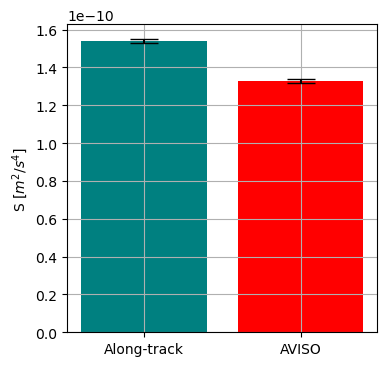

In [8]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(4,4))

ax.bar(0.5, ds['sum_'+id_co], yerr =mserr['sum_'+id_co],  color ='teal',width = 0.4, capsize=10)
ax.bar(1, ds['sum_'+id_aviso], yerr =mserr['sum_'+id_aviso], color ='red',width = 0.4, capsize=10)

ax.grid()

ticks = ('Along-track', 'AVISO')
ax.set_xticks([0.5, 1], ticks,)
ax.set_ylabel(r'S $[m^2/s^4]$')

Text(0, 0.5, '$nS$ [%]')

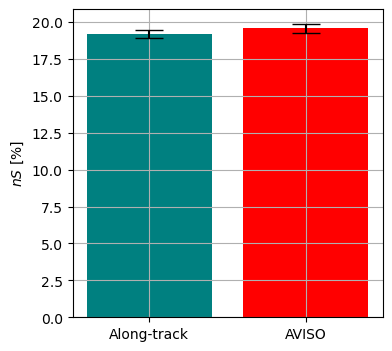

In [9]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(4,4))

ax.bar(0.5, nMSRe_id(ds,mserr, id_co)[0],yerr = nMSRe_id(ds,mserr, id_co)[1], color ='teal',width = 0.4, capsize=10)
ax.bar(1, nMSRe_id(ds,mserr, id_aviso)[0], yerr = nMSRe_id(ds, mserr,id_aviso)[1], color ='red',width = 0.4, capsize=10)

ax.grid()

ticks = ('Along-track', 'AVISO')
ax.set_xticks([0.5, 1], ticks,)
ax.set_ylabel(r'$nS$ [%]')

______________________
# $A$ contribution : $C_{a} =\langle S_{-a_i}^2\rangle-\langle S^2 \rangle$ 

In [10]:
CX = C_x(ds,mserr, [id_co, id_aviso])

In [11]:
CX

,acc,coriolis,ggrad,wind,acc_err,coriolis_err,ggrad_err,wind_err
id_comb,,,,,,,,
co__25__adt_filtered_ocean_tide_internal_tide__es_cstrio_z15__drifter_x,5.991709e-11,2.470746e-10,1.761768e-10,1.166408e-11,2.746826e-12,4.144737e-12,3.615190e-12,2.386416e-12
aviso__25__adt__es_cstrio_z15__alti_x,2.100680e-11,1.829884e-10,1.971870e-10,1.174575e-11,2.141596e-12,3.351464e-12,3.457515e-12,2.072424e-12


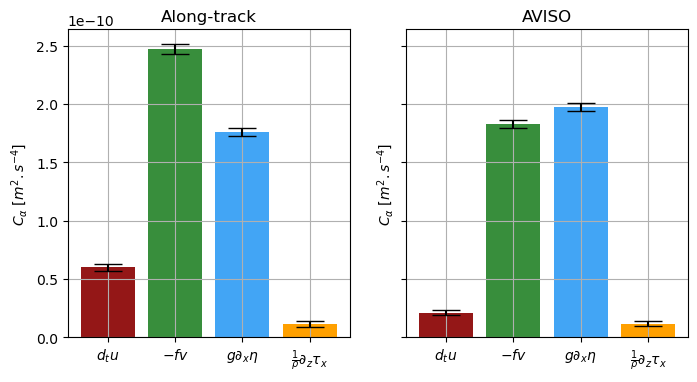

In [12]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(8,4), sharey=True)
ax=axs[0]
df = CX.loc[id_co]
ax.bar(0.5, df.acc, yerr=df.acc_err, color =c0['acc'],width = 0.4, capsize=10)
ax.bar(1, df.coriolis,yerr=df.coriolis_err, color =c0['coriolis'],width = 0.4, capsize=10)
ax.bar(1.5, df.ggrad,yerr=df.ggrad_err, color =c0['ggrad'],width = 0.4, capsize=10)
ax.bar(2, df.wind,yerr=df.wind_err, color =c0['wind'],width = 0.4, capsize=10)
ax.set_title('Along-track')

ax=axs[1]
df = CX.loc[id_aviso]
ax.bar(0.5, df.acc,yerr=df.acc_err, color =c0['acc'],width = 0.4, capsize=10)
ax.bar(1, df.coriolis,yerr=df.coriolis_err, color =c0['coriolis'],width = 0.4, capsize=10)
ax.bar(1.5, df.ggrad,yerr=df.ggrad_err, color =c0['ggrad'],width = 0.4, capsize=10)
ax.bar(2, df.wind,yerr=df.wind_err, color =c0['wind'],width = 0.4, capsize=10)
ax.set_title('AVISO')

for ax in axs :
    ax.grid()
    ticks = (r'$d_tu$', r'$-fv$', r'$g \partial_x \eta$', r'$\frac{1}{\rho}\partial_z\tau_x$')
    ax.set_xticks([0.5, 1, 1.5, 2], ticks,)
    ax.set_ylabel(r'$C_{\alpha}$ $[m^2.s^{-4}]$')
    

_____________
# Correlation + balanced/error parts

$$ B_i  = \frac{1}{2} (A_i  - S +S_{-i}) = - \sum_{j\neq i} \langle a_i a_j \rangle = - \langle a_i s_{-i}\rangle $$
$$ E_i  = \frac{1}{2} (A_i  + S -S_{-i}) =  \langle a_i s \rangle $$

In [13]:
def global_cor(dsc):
    #global ms
    cor = (((dsc*dsc.nb_coloc).sum('drifter_sat_year'))/(dsc.nb_coloc.sum('drifter_sat_year'))).drop('nb_coloc')
    print(dsc.nb_coloc.sum('drifter_sat_year'))
    for v in dsc.keys():
        if v != 'nb_coloc':
            cor[v].attrs=dsc[v].attrs
    
    #nb_coloc
    nb_coloc = dsc.nb_coloc.sum('drifter_sat_year')
    cor['nb_coloc']=nb_coloc
    return cor

In [16]:
import itertools
from histlib.diagnosis import global_drifter_sat, error_on_covariances
corr_key_co = list(itertools.combinations(list(id_co_dic.values()),2))
corr_key_av = list(itertools.combinations(list(id_aviso_dic.values()),2)) 
corr_var_co = ["prod_"+ab[0]+"__"+ab[1] for ab in corr_key_co]
corr_var_aviso = ["prod_"+ab[0]+"__"+ab[1] for ab in corr_key_av]

dsc = xr.open_dataset(os.path.join(zarr_dir+'_ok','global',f'corr_{int(DL//1000)}_{DT}_drogued.zarr'))[corr_var_co+['nb_coloc']]
dscor_co = global_drifter_sat(dsc)
dscor_co_err = error_on_covariances(dscor_co, ds , corr_key_co, alpha=0.0001)

dsc = xr.open_dataset(os.path.join(zarr_dir+'_ok','global',f'corr_{int(DL//1000)}_{DT}_drogued.zarr'))[corr_var_aviso+['nb_coloc']]
dscor_aviso = global_drifter_sat(dsc)
dscor_aviso_err = error_on_covariances(dscor_aviso, ds , corr_key_av, alpha=0.0001)


<xarray.DataArray 'nb_coloc' ()>
array(237860)
<xarray.DataArray 'nb_coloc' ()>
array(237860)


In [17]:
dscor_co_err

<xarray.Dataset>
Dimensions:                                                                          ()
Data variables:
    prod_drifter_acc_x_25__drifter_coriolis_x_25                                     float64 ...
    prod_drifter_acc_x_25__alti_ggx_adt_filtered_ocean_tide_internal_tide            float64 ...
    prod_drifter_acc_x_25__es_cstrio_z15_drifter_wd_x                                float64 ...
    prod_drifter_coriolis_x_25__alti_ggx_adt_filtered_ocean_tide_internal_tide       float64 ...
    prod_drifter_coriolis_x_25__es_cstrio_z15_drifter_wd_x                           float64 ...
    prod_alti_ggx_adt_filtered_ocean_tide_internal_tide__es_cstrio_z15_drifter_wd_x  float64 ...
    nb_coloc                                                                         int64 ...

In [18]:
dsms = xr.concat([true_err_x(ds,mserr, id_co), true_err_x(ds,mserr, id_aviso)], dim=pd.Index([id_co, id_aviso], name = 'id_comb'))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(75.09722222222221, 0.5, '$[m^2.s^{-4}]$')

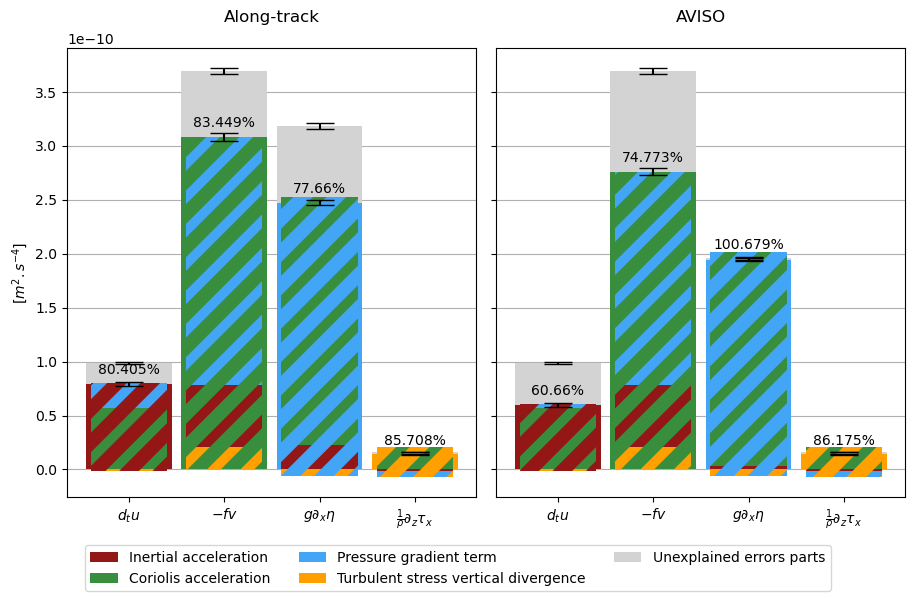

In [19]:
fig, ax = plt.subplots(1,2,figsize=(9,6), sharey=True)
plot_true_err_cor_part(dsms.sel(id_comb=id_co), dscor_co, id_co_dic, ax[0], title='Along-track', rd=3)
plot_true_err_cor_part(dsms.sel(id_comb=id_aviso), dscor_aviso, id_aviso_dic, ax[1], title='AVISO', legend=False, rd=3)
fig.legend(ncol=3,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.08,1,1])#left, bottom, right, top (default is 0,0,1,1)
ax[0].set_ylabel(r'$[m^2.s^{-4}]$')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(75.09722222222221, 0.5, '$[m^2.s^{-4}]$')

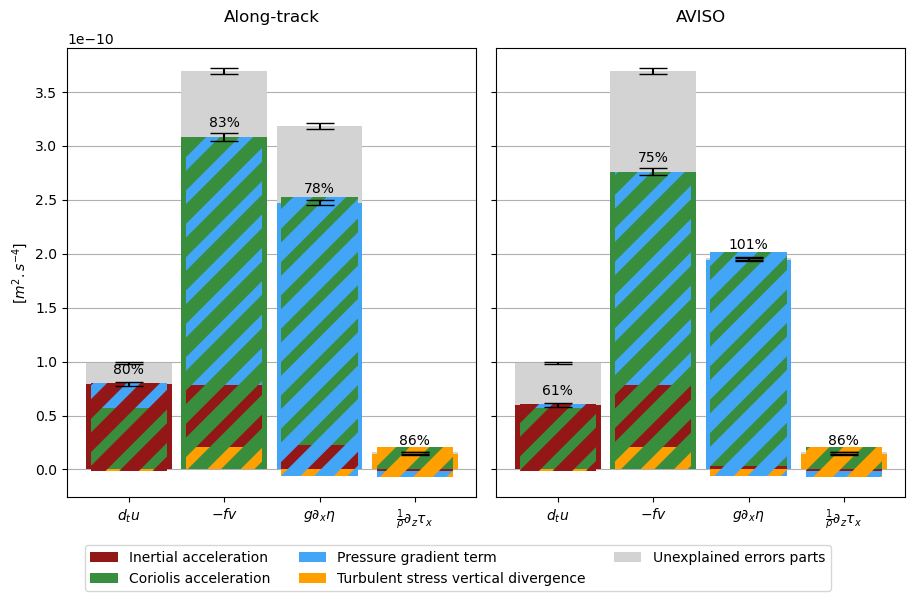

In [20]:
fig, ax = plt.subplots(1,2,figsize=(9,6), sharey=True)
plot_true_err_cor_part(dsms.sel(id_comb=id_co), dscor_co, id_co_dic, ax[0], title='Along-track')
plot_true_err_cor_part(dsms.sel(id_comb=id_aviso), dscor_aviso, id_aviso_dic, ax[1], title='AVISO', legend=False)
fig.legend(ncol=3,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.08,1,1])#left, bottom, right, top (default is 0,0,1,1)
ax[0].set_ylabel(r'$[m^2.s^{-4}]$')

#  Compare pair's contribution to errors 

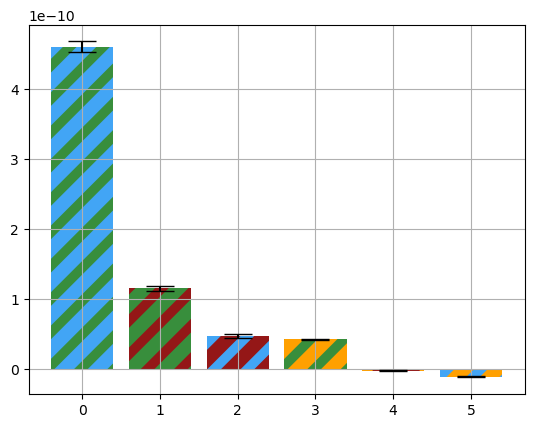

In [21]:
fig, ax = plt.subplots()
plt.rcParams["axes.edgecolor"] = "k"
dsc = -2 *dscor_co
dsce = 2 *dscor_co_err
dic = id_co_dic
def vn(id_dic, key1, key2):
    return 'prod_'+id_dic[key1]+'__'+id_dic[key2]
plt.rcParams['hatch.linewidth'] = 10
plt.rcParams['hatch.color'] = c0['ggrad']
ax.bar(0, dsc[vn(dic, 'coriolis', 'ggrad')], color=c0['coriolis'], hatch='/', yerr = dsce[vn(dic, 'coriolis', 'ggrad')], capsize=10)
plt.rcParams['hatch.color'] = c0['coriolis']
ax.bar(1, dsc[vn(dic, 'acc', 'coriolis')], color=c0['acc'], hatch='/', yerr = dsce[vn(dic, 'acc', 'coriolis')], capsize=10)
plt.rcParams['hatch.color'] = c0['acc']
ax.bar(2, dsc[vn(dic, 'acc', 'ggrad')], color=c0['ggrad'], hatch='/', yerr = dsce[vn(dic, 'acc', 'ggrad')], capsize=10)
plt.rcParams['hatch.color'] = c0['wind']
ax.bar(3, dsc[vn(dic, 'coriolis', 'wind')], color=c0['coriolis'], hatch='/', yerr = dsce[vn(dic, 'coriolis', 'wind')], capsize=10 )
plt.rcParams['hatch.color'] = c0['wind']
ax.bar(4, dsc[vn(dic, 'acc', 'wind')], color=c0['acc'], hatch='/', yerr = dsce[vn(dic, 'acc', 'wind')], capsize=10 )
plt.rcParams['hatch.color'] = c0['wind']
ax.bar(5, dsc[vn(dic, 'ggrad', 'wind')], color=c0['ggrad'], hatch='/', yerr = dsce[vn(dic, 'ggrad', 'wind')], capsize=10 )

ax.grid()

_________
_________
# Synthetic figure

In [22]:
def synthetic_figure(ds, dsc, dic, ax, xlim=None) :
    plt.rcParams["axes.edgecolor"] = "w"
    a=1.5
    bbox = dict(facecolor='w', alpha=0.8, edgecolor='w')
    def vn(id_dic, key1, key2):
        return 'prod_'+id_dic[key1]+'__'+id_dic[key2]
    
    ts = ds['acc']+ds['coriolis']+ds['ggrad']+ds['wind']
    print(ts)
    #gap between bars for readability
    if xlim : b=xlim/400
    else : b=ts/400
    
    ## INDIVIDUAL MS ##
    ax.barh(2*a, ds['acc'], color= c0['acc'], label = 'Inertial acceleration')
    ax.barh(2*a, ds['coriolis'], left =ds['acc']+b , color= c0['coriolis'], label = 'Coriolis acceleration')
    ax.barh(2*a, ds['ggrad'], left =ds['acc']+ds['coriolis']+2*b , color= c0['ggrad'], label = 'Pressure gradient term')
    ax.barh(2*a, ds['wind'], left =ds['acc']+ds['coriolis']+ds['ggrad']+3*b, color= c0['wind'], label = 'Wind term')
    

    ax.text(ts/2, 2*a+0.5, r'Individual MS $A_i$', ha='center') 
    #percentage + MS
    key = ['acc', 'coriolis', 'ggrad', 'wind']
    for i in range(len(key)) :
        ax.text(sum([ds[v] for v in key[:i]])+ds[key[i]]/2+i*b, 2*a, f'{int(np.rint((ds[key[i]]/ts).values*100))} %', ha='center',bbox=bbox )
        ax.text(sum([ds[v] for v in key[:i]])+ds[key[i]]/2+i*b, 2*a-0.55, f'{np.format_float_scientific(ds[key[i]].values,precision = 1)}', ha='center')
    
    #accolade
    c = 1e-12
    id1 =0
    id2 = ts + 3*b
    bx = [id1, id1, id2, id2]
    by = [3.70, 3.75, 3.75, 3.70]
    ax.plot(bx, by, 'k-', lw=2)
    ax.text(ts, 3.8, r'$\Sigma$', fontsize=15, ha='center')
    
    ## CAPTURED PHYSICAL + ERRORS PARTS ##
    ax.barh(1*a, ds['true_acc'], color= c0['acc'])
    ax.barh(1*a, ds['err_acc'], left = ds['true_acc'], color= 'lightgrey', label='Errors')
    ax.barh(1*a, ds['true_coriolis'], left =ds['true_acc']+ds['err_acc']+b, color= c0['coriolis'])
    ax.barh(1*a, ds['err_coriolis'], left =ds['true_acc']+ds['err_acc']+ ds['true_coriolis'], color= 'lightgrey')
    ax.barh(1*a, ds['true_ggrad'], left =ds['true_acc']+ds['err_acc']+ ds['true_coriolis']+ ds['err_coriolis']+b, color= c0['ggrad'])
    if ds['err_ggrad']>0 : 
        ax.barh(1*a, ds['err_ggrad'], left =ds['true_acc']+ds['err_acc']+ ds['true_coriolis']+ ds['err_coriolis']+ds['true_ggrad'], color= 'lightgrey')
        ax.barh(1*a, ds['true_wind'], left =ds['true_acc']+ds['err_acc']+ ds['true_coriolis']+ ds['err_coriolis']+ds['true_ggrad']+ds['err_ggrad']+b, color= c0['wind'])
        ax.barh(1*a, ds['err_wind'], left =ds['true_acc']+ds['err_acc']+ ds['true_coriolis']+ ds['err_coriolis']+ds['true_ggrad']+ds['err_ggrad']+ds['true_wind'], color= 'lightgrey')
    else : 
        print('ok')
        ax.barh(1*a, ds['true_wind'], left =ds['true_acc']+ds['err_acc']+ ds['true_coriolis']+ ds['err_coriolis']+ds['true_ggrad']+2*b, color= c0['wind'])
        ax.barh(1*a, ds['err_wind'], left =ds['true_acc']+ds['err_acc']+ ds['true_coriolis']+ ds['err_coriolis']+ds['true_ggrad']+ds['true_wind']+2*b, color= 'lightgrey')
    
    ax.text(ts/2, 1*a+0.5, r'Balanced physical and errors parts MS $B_i$ and $E_i$', ha='center') 
    #percentage + MS
    key = ['true_acc','err_acc', 'true_coriolis','err_coriolis', 'true_ggrad','err_ggrad', 'true_wind', 'err_wind']
    for i in range(len(key)) :
        d=0
        dx=0
        if i==len(key)-1 : 
            d=-0.1*a 
            dx = 3e-11
        if i==len(key)-2 : d=0.1*a 
        if 'aviso' in dic['ggrad'] and i==len(key)-3 : d=-0.1*a
        ax.text(sum([ds[v] for v in key[:i]])+ds[key[i]]/2+i*b/2, a+d, f'{int(np.rint((ds[key[i]]/ts).values*100))} %', ha='center', bbox=bbox)
        d=0        
        if i%2 ==1 : d=-0.1*a
        ax.text(sum([ds[v] for v in key[:i]])+ds[key[i]]/2+i*b/2+dx, a+d -0.55, f'{np.format_float_scientific(ds[key[i]].values,precision = 1)}', ha='center')
        
    ## PAIRS + RESIDUAL ##
    plt.rcParams['hatch.linewidth'] = 10
    plt.rcParams['hatch.color'] = c0['ggrad']
    ax.barh(0, dsc[vn(dic, 'coriolis', 'ggrad')], color=c0['coriolis'], hatch='/')
    plt.rcParams['hatch.color'] = c0['coriolis']
    ax.barh(0, dsc[vn(dic, 'acc', 'coriolis')], color=c0['acc'], hatch='/', left = dsc[vn(dic, 'coriolis', 'ggrad')]+b)
    plt.rcParams['hatch.color'] = c0['acc']
    ax.barh(0, dsc[vn(dic, 'acc', 'ggrad')], color=c0['ggrad'], hatch='/', left = dsc[vn(dic, 'coriolis', 'ggrad')]+dsc[vn(dic, 'acc', 'coriolis')]+2*b)
    plt.rcParams['hatch.color'] = c0['wind']
    ax.barh(0, dsc[vn(dic, 'coriolis', 'wind')], color=c0['coriolis'], hatch='/', left = dsc[vn(dic, 'coriolis', 'ggrad')]+dsc[vn(dic, 'acc', 'coriolis')]+dsc[vn(dic, 'acc', 'ggrad')]+3*b)
    ax.barh(0, ds['S'], color='lightgrey', left = dsc[vn(dic, 'coriolis', 'ggrad')]+dsc[vn(dic, 'acc', 'coriolis')]+dsc[vn(dic, 'acc', 'ggrad')]+dsc[vn(dic, 'coriolis', 'wind')]+4*b)

    tts = dsc[vn(dic, 'coriolis', 'ggrad')]+dsc[vn(dic, 'acc', 'coriolis')]+dsc[vn(dic, 'acc', 'ggrad')]+dsc[vn(dic, 'coriolis', 'wind')]+4*b+ds['S']
    print(tts)
    sum_pairs = dsc[vn(dic, 'coriolis', 'ggrad')]+dsc[vn(dic, 'acc', 'coriolis')]+dsc[vn(dic, 'acc', 'ggrad')]+dsc[vn(dic, 'coriolis', 'wind')]+3*b
    ax.text(sum_pairs/2, 0.6, r"Pairs' contributions $X_{ij}$", ha='center')
    #accolade
    c = 1e-12
    id1 =0
    id2 = sum_pairs
    bx = [id1, id1, id2, id2]
    by = [0.45, 0.5, 0.5, 0.45]
    ax.plot(bx, by, 'k-', lw=2)
    ax.text(sum_pairs + ds['S']/2, 0.5, r'$S$', ha='center')

    #percentage + MS
    key = [vn(dic, 'coriolis', 'ggrad'),vn(dic, 'acc', 'coriolis'), vn(dic, 'acc', 'ggrad'), vn(dic, 'coriolis', 'wind')]
    for i in range(len(key)) :
        ax.text(sum([dsc[v] for v in key[:i]])+dsc[key[i]]/2+i*b, 0, f'{int(np.rint((dsc[key[i]]/ts).values*100))} %', ha='center', bbox=bbox)
        d=0
        if 'aviso' in dic['ggrad'] and key[i]== vn(dic, 'acc', 'ggrad') : d = -0.1*a
        ax.text(sum([dsc[v] for v in key[:i]])+dsc[key[i]]/2+i*b, 0-0.55+d, f'{np.format_float_scientific(dsc[key[i]].values,precision = 1)}', ha='center')
    
    ax.text(sum([dsc[v] for v in key])+ds['S']/2+i*b, 0, f'{int(np.rint((ds["S"]/ts).values*100))} %', ha='center', bbox=bbox)
    ax.text(sum([dsc[v] for v in key])+ds['S']/2+i*b, 0-0.55, f'{np.format_float_scientific(ds["S"].values,precision = 1)}', ha='center')

    # FIGURE SET
    ax.set_yticks([])
    if not xlim : xlim=tts
    ax.set_xlim(-1e-11, xlim+1e-11)
    ax.set_ylim(-1, 4.1)
    ax.get_yaxis().set_visible(False)
    ax.annotate('',xy=(xlim,-1),xytext=(0,-1),arrowprops={'arrowstyle':'->', 'facecolor':'k'})
    ax.set_xlabel(r'$[m^2.s^{-4}]$')
    

<xarray.DataArray ()>
array(8.02670831e-10)
Coordinates:
    id_comb  <U71 'co__25__adt_filtered_ocean_tide_internal_tide__es_cstrio_z...
<xarray.DataArray ()>
array(8.24545969e-10)
Coordinates:
    id_comb  <U71 'co__25__adt_filtered_ocean_tide_internal_tide__es_cstrio_z...


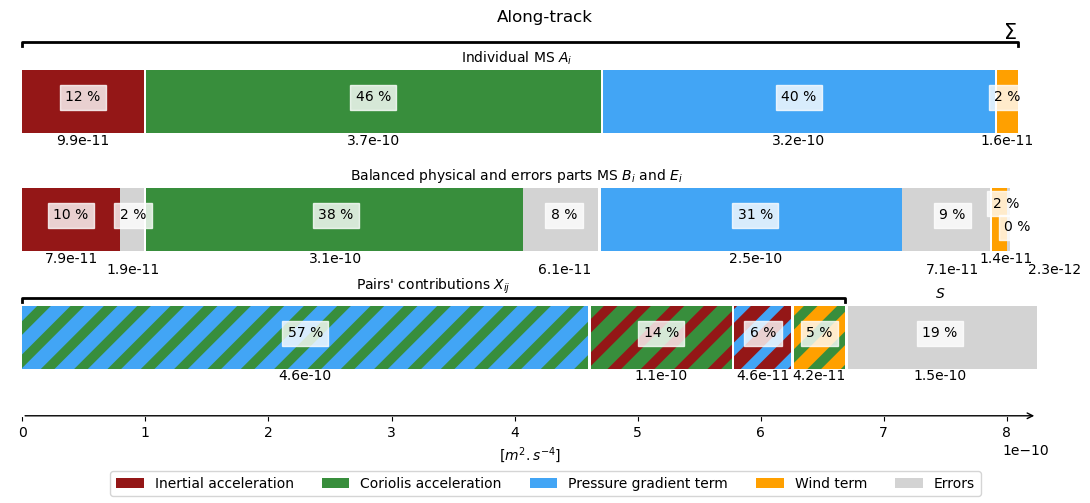

In [23]:
plt.rcParams["axes.edgecolor"] = "w"
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(11,5), frameon=False, )

synthetic_figure(dsms.sel(id_comb=id_co), -2*dscor_co, id_co_dic, ax) 
fig.legend(ncol=5,loc='lower center')
fig.tight_layout(rect=[0,0.04,1,1])#left, bottom, right, top (default is 0,0,1,1)
fig.suptitle('Along-track')
fig.savefig('images_all/synth_alg.png',bbox_inches='tight',   dpi=300)

In [24]:
dsms.sel(id_comb=id_co)

<xarray.Dataset>
Dimensions:            ()
Coordinates:
    id_comb            <U71 'co__25__adt_filtered_ocean_tide_internal_tide__e...
Data variables: (12/29)
    acc                float64 9.853e-11
    acc_err            float64 7.36e-13
    exc_acc            float64 2.138e-10
    true_acc           float64 7.922e-11
    true_acc_err       float64 1.741e-12
    err_acc            float64 1.931e-11
    ...                 ...
    exc_wind           float64 1.656e-10
    true_wind          float64 1.4e-11
    true_wind_err      float64 1.254e-12
    err_wind           float64 2.334e-12
    err_wind_err       float64 1.254e-12
    S                  float64 1.539e-10

<xarray.DataArray ()>
array(6.78645909e-10)
Coordinates:
    id_comb  <U37 'aviso__25__adt__es_cstrio_z15__alti_x'
ok
<xarray.DataArray ()>
array(6.99231262e-10)
Coordinates:
    id_comb  <U37 'aviso__25__adt__es_cstrio_z15__alti_x'


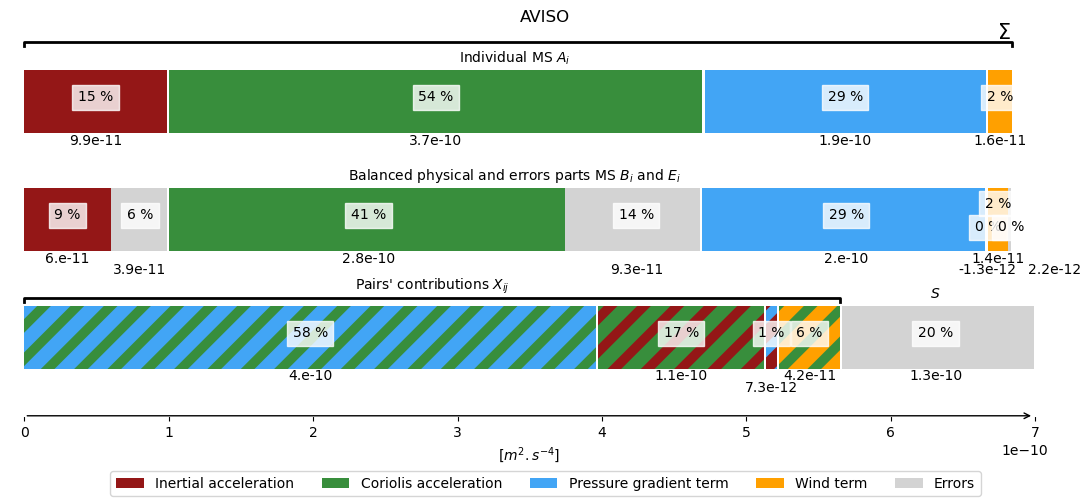

In [25]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(11,5), frameon=False)
synthetic_figure(dsms.sel(id_comb=id_aviso), -2*dscor_aviso, id_aviso_dic, ax) 
fig.legend(ncol=5,loc='lower center')
fig.tight_layout(rect=[0,0.04,1,1])#left, bottom, right, top (default is 0,0,1,1)
fig.suptitle('AVISO')
fig.savefig('images_all/synth_aviso.png',bbox_inches='tight',   dpi=300)

<xarray.DataArray ()>
array(8.02670831e-10)
Coordinates:
    id_comb  <U71 'co__25__adt_filtered_ocean_tide_internal_tide__es_cstrio_z...
<xarray.DataArray ()>
array(8.2521926e-10)
Coordinates:
    id_comb  <U71 'co__25__adt_filtered_ocean_tide_internal_tide__es_cstrio_z...
<xarray.DataArray ()>
array(6.78645909e-10)
Coordinates:
    id_comb  <U37 'aviso__25__adt__es_cstrio_z15__alti_x'
ok
<xarray.DataArray ()>
array(7.01144803e-10)
Coordinates:
    id_comb  <U37 'aviso__25__adt__es_cstrio_z15__alti_x'


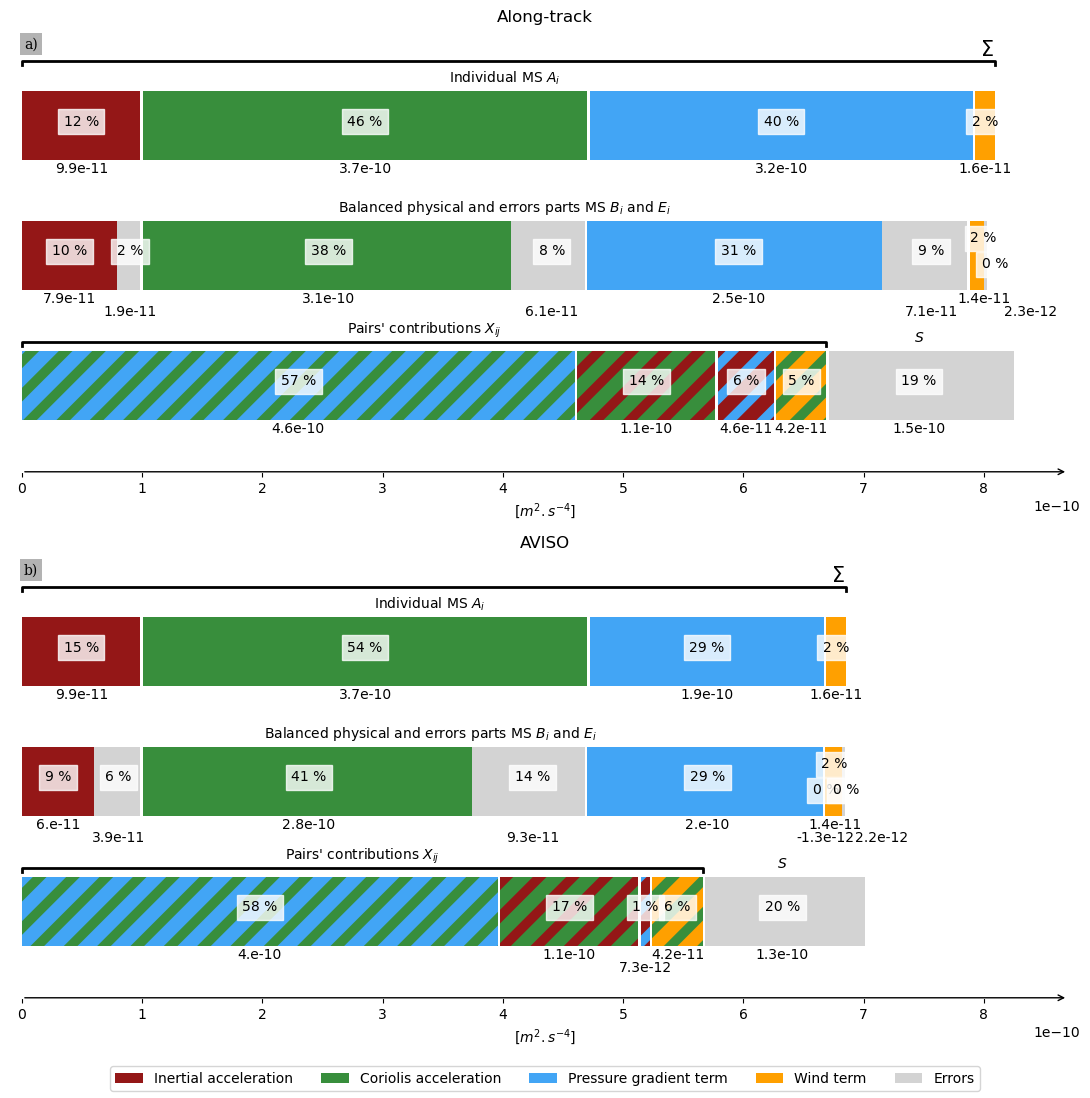

In [26]:
fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(11,11), frameon=False, )
plt.rcParams["axes.edgecolor"] = "w"

synthetic_figure(dsms.sel(id_comb=id_co), -2*dscor_co, id_co_dic, axs[0], xlim=8.7e-10) 
synthetic_figure(dsms.sel(id_comb=id_aviso), -2*dscor_aviso, id_aviso_dic, axs[1], xlim=8.7e-10) 

axs[0].set_title('Along-track')
axs[1].set_title('AVISO')

handles, labels = axs[0].get_legend_handles_labels()

put_fig_letter(axs[0], 'a')
put_fig_letter(axs[1], 'b')
fig.legend(handles, labels, ncol=5,loc='lower center')
fig.tight_layout(rect=[0,0.03,1,1])#left, bottom, right, top (default is 0,0,1,1)
fig.savefig('images_all/synth_samex.png',bbox_inches='tight',   dpi=300)

<xarray.DataArray ()>
array(8.02670831e-10)
Coordinates:
    id_comb  <U71 'co__25__adt_filtered_ocean_tide_internal_tide__es_cstrio_z...
<xarray.DataArray ()>
array(8.2521926e-10)
Coordinates:
    id_comb  <U71 'co__25__adt_filtered_ocean_tide_internal_tide__es_cstrio_z...


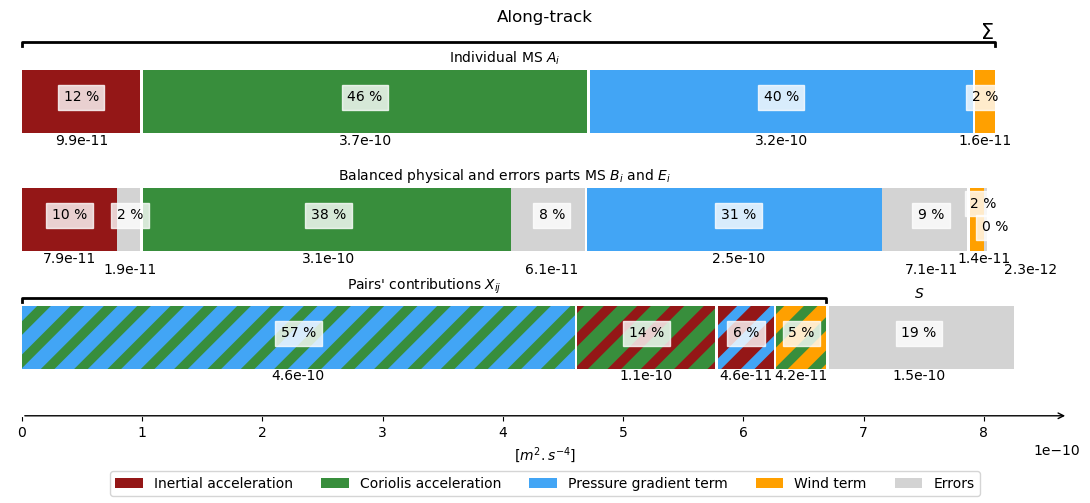

In [27]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(11,5), frameon=False)
synthetic_figure(dsms.sel(id_comb=id_co), -2*dscor_co, id_co_dic, ax, xlim=8.7e-10) 
fig.legend(ncol=5,loc='lower center')
fig.tight_layout(rect=[0,0.04,1,1])#left, bottom, right, top (default is 0,0,1,1)
fig.suptitle('Along-track')
fig.savefig('images_all/synth_alg_samex.png',bbox_inches='tight',   dpi=300)

<xarray.DataArray ()>
array(6.78645909e-10)
Coordinates:
    id_comb  <U37 'aviso__25__adt__es_cstrio_z15__alti_x'
ok
<xarray.DataArray ()>
array(7.01144803e-10)
Coordinates:
    id_comb  <U37 'aviso__25__adt__es_cstrio_z15__alti_x'


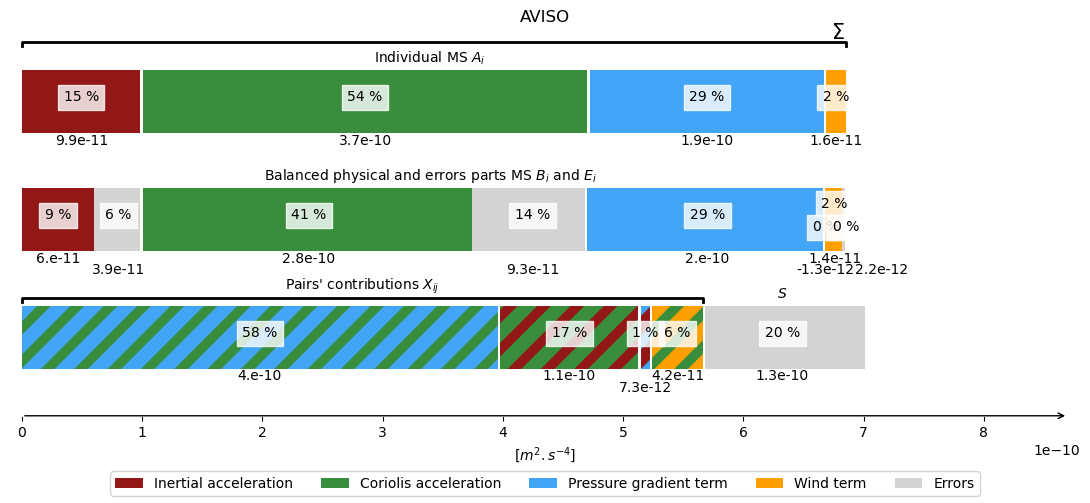

In [28]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(11,5), frameon=False)
synthetic_figure(dsms.sel(id_comb=id_aviso), -2*dscor_aviso, id_aviso_dic, ax, xlim=8.7e-10) 
fig.legend(ncol=5,loc='lower center')
fig.tight_layout(rect=[0,0.04,1,1])#left, bottom, right, top (default is 0,0,1,1)
fig.suptitle('AVISO')
fig.savefig('images_all/synth_aviso_samex.png',bbox_inches='tight',   dpi=300)

_________
_________
# Errors

In [29]:
coloc_err = {'acc':1.2e-12, 'coriolis':1.5e-11, 'ggrad':1.7e-11,}

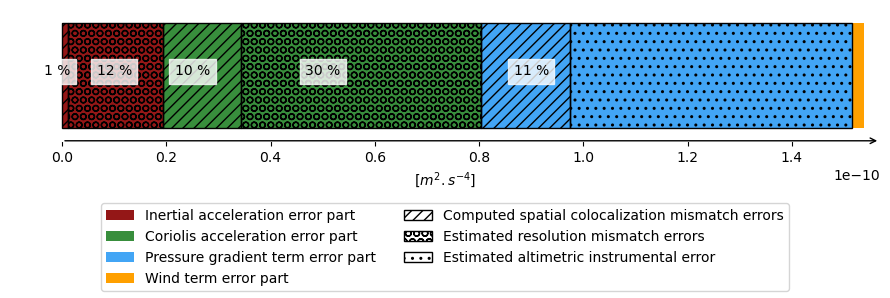

In [30]:
def synthetic_figure_errors(ds, dsc, dic, ax, coloc_err, xlim=None) :
    plt.rcParams["axes.edgecolor"] = "w"
    a=1.5
    bbox = dict(facecolor='w', alpha=0.8, edgecolor='w')
    def vn(id_dic, key1, key2):
        return 'prod_'+id_dic[key1]+'__'+id_dic[key2]
    
    ts = ds['acc']+ds['coriolis']+ds['ggrad']+ds['wind']
    
    #gap between bars for readability
    if xlim : b=xlim/400
    else : b=ts/400
        
    ## PAIRS + RESIDUAL ##
    plt.rcParams['hatch.linewidth'] = 1
    plt.rcParams['hatch.color'] = 'k'
    ax.barh(0, ds['S'],left=0.9, color='lightgrey')
    ax.barh(0, ds['err_acc'], color= c0['acc'], label='Inertial acceleration error part')
    ax.barh(0, ds['err_coriolis'], left =ds['err_acc'], color= c0['coriolis'], label='Coriolis acceleration error part')
    if ds['err_ggrad']>0 : 
        ax.barh(0, ds['err_ggrad'], left =ds['err_acc']+ ds['err_coriolis'], color= c0['ggrad'], label='Pressure gradient term error part')
        ax.barh(0, ds['err_wind'], left =ds['err_acc']+ds['err_coriolis']+ds['err_ggrad'], color= c0['wind'], label='Wind term error part')
    else : 
        print('ok')
        ax.barh(0, ds['err_wind'], left = ds['err_acc']+  ds['err_coriolis']+2*b, color= c0['wind'])

    ##COLOCALIZATION ERRORS
    ax.barh(0, coloc_err['acc'], hatch='///', fill=False, label='Computed spatial colocalization mismatch errors')#,color=None )
    ax.barh(0, coloc_err['coriolis'], left = ds['err_acc'], hatch='///', fill=False)
    ax.barh(0, coloc_err['ggrad'], left = ds['err_acc']+ds['err_coriolis'], hatch='///', fill=False)
    
    ax.text(-1e-12,0, f"{int(np.rint((coloc_err['acc']/ds['S']).values*100))} %", ha='center', bbox=bbox)
    ax.text(0.25e-10,0, f"{int(np.rint((coloc_err['coriolis']/ds['S']).values*100))} %", ha='center', bbox=bbox)
    ax.text(0.9e-10,0, f"{int(np.rint((coloc_err['ggrad']/ds['S']).values*100))} %", ha='center', bbox=bbox)
    
    ##RESOLUTION ERRORS
    ax.barh(0, ds['err_acc']-coloc_err['acc'], left=coloc_err['acc'], hatch='OO', fill=False, label='Estimated resolution mismatch errors')
    ax.barh(0, ds['err_coriolis']-coloc_err['coriolis'], left=ds['err_acc']+coloc_err['coriolis'], hatch='OO', fill=False)

    ax.text(0.1e-10,0, f"{int(np.rint(((ds['err_acc']-coloc_err['acc'])/ds['S']).values*100))} %", ha='center', bbox=bbox)
    ax.text(0.5e-10,0, f"{int(np.rint(((ds['err_coriolis']-coloc_err['coriolis'])/ds['S']).values*100))} %", ha='center', bbox=bbox)

    ##INSTRUMANTAL ERRORS
    ax.barh(0, ds['err_ggrad']-coloc_err['ggrad'], left=ds['err_acc']+ds['err_coriolis']+coloc_err['ggrad'], hatch='..', fill=False, label='Estimated altimetric instrumental error')
  
    # FIGURE SET
    ax.set_yticks([])
    if not xlim : xlim=ds['S']
    ax.set_xlim(-1e-11, xlim+3e-12)
    ax.set_ylim(-0.5,0.5)
    ax.get_yaxis().set_visible(False)
    ax.annotate('',xy=(xlim+3e-12,-0.5),xytext=(0,-0.5),arrowprops={'arrowstyle':'->', 'facecolor':'k'})
    ax.set_xlabel(r'$[m^2.s^{-4}]$')

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(9,3), frameon=False)
synthetic_figure_errors(dsms.sel(id_comb=id_co), -2*dscor_co, id_co_dic, ax, coloc_err) 
fig.legend(ncol=2,loc='lower center')
fig.tight_layout(rect=[0,0.3,1,1])#left, bottom, right, top (default is 0,0,1,1)

fig.savefig('images_all/synth_err_alg.png',bbox_inches='tight',   dpi=300)

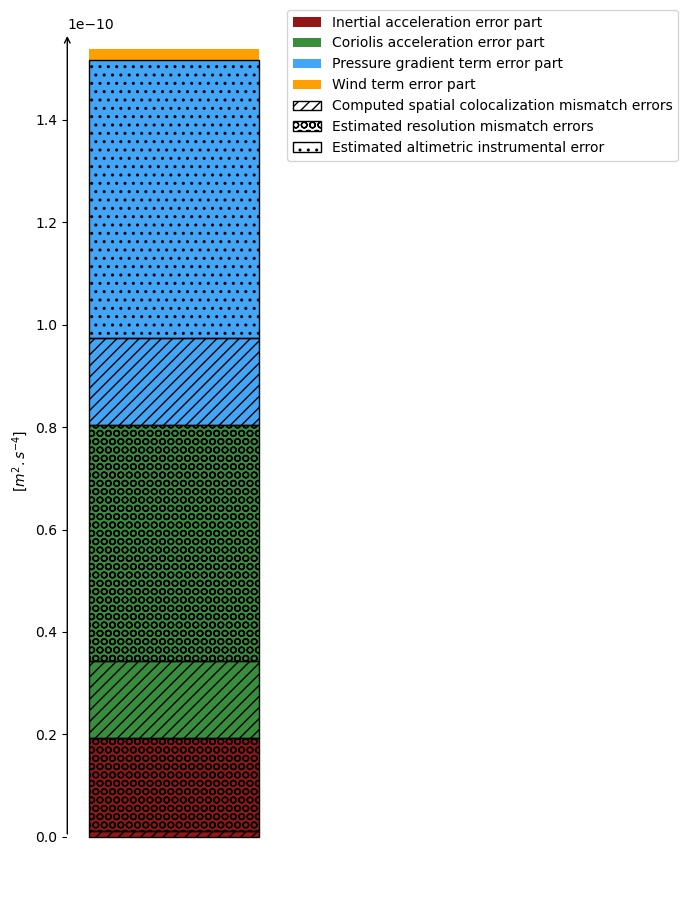

In [31]:
def synthetic_figure_errors_vert(ds, dsc, dic, ax, coloc_err, xlim=None) :
    plt.rcParams["axes.edgecolor"] = "w"
    a=1.5
    bbox = dict(facecolor='w', alpha=0.8, edgecolor='w')
    def vn(id_dic, key1, key2):
        return 'prod_'+id_dic[key1]+'__'+id_dic[key2]
    
    ts = ds['acc']+ds['coriolis']+ds['ggrad']+ds['wind']
    
    #gap between bars for readability
    if xlim : b=xlim/400
    else : b=ts/400
        
    ## PAIRS + RESIDUAL ##
    plt.rcParams['hatch.linewidth'] = 1
    plt.rcParams['hatch.color'] = 'k'
    ax.bar(0, ds['S'], color='lightgrey')
    ax.bar(0, ds['err_acc'], color= c0['acc'], label='Inertial acceleration error part')
    ax.bar(0, ds['err_coriolis'], bottom =ds['err_acc'], color= c0['coriolis'], label='Coriolis acceleration error part')
    if ds['err_ggrad']>0 : 
        ax.bar(0, ds['err_ggrad'], bottom =ds['err_acc']+ ds['err_coriolis'], color= c0['ggrad'], label='Pressure gradient term error part')
        ax.bar(0, ds['err_wind'], bottom =ds['err_acc']+ds['err_coriolis']+ds['err_ggrad'], color= c0['wind'], label='Wind term error part')
    else : 
        print('ok')
        ax.bar(0, ds['err_wind'], bottom = ds['err_acc']+  ds['err_coriolis']+2*b, color= c0['wind'])

    ##COLOCALIZATION ERRORS
    ax.bar(0, coloc_err['acc'], hatch='///', fill=False, label='Computed spatial colocalization mismatch errors')#,color=None )
    ax.bar(0, coloc_err['coriolis'], bottom = ds['err_acc'], hatch='///', fill=False)
    ax.bar(0, coloc_err['ggrad'], bottom = ds['err_acc']+ds['err_coriolis'], hatch='///', fill=False)
    
    #ax.text(-1e-12,0, f"{int(np.rint((coloc_err['acc']/ds['S']).values*100))} %", ha='center', bbox=bbox)
    #ax.text(0.25e-10,0, f"{int(np.rint((coloc_err['coriolis']/ds['S']).values*100))} %", ha='center', bbox=bbox)
    #ax.text(0.9e-10,0, f"{int(np.rint((coloc_err['ggrad']/ds['S']).values*100))} %", ha='center', bbox=bbox)
    
    ##RESOLUTION ERRORS
    ax.bar(0, ds['err_acc']-coloc_err['acc'], bottom=coloc_err['acc'], hatch='OO', fill=False, label='Estimated resolution mismatch errors')
    ax.bar(0, ds['err_coriolis']-coloc_err['coriolis'], bottom=ds['err_acc']+coloc_err['coriolis'], hatch='OO', fill=False)

    #ax.text(0.1e-10,0, f"{int(np.rint(((ds['err_acc']-coloc_err['acc'])/ds['S']).values*100))} %", ha='center', bbox=bbox)
    #ax.text(0.5e-10,0, f"{int(np.rint(((ds['err_coriolis']-coloc_err['coriolis'])/ds['S']).values*100))} %", ha='center', bbox=bbox)

    ##INSTRUMANTAL ERRORS
    ax.bar(0, ds['err_ggrad']-coloc_err['ggrad'], bottom=ds['err_acc']+ds['err_coriolis']+coloc_err['ggrad'], hatch='..', fill=False, label='Estimated altimetric instrumental error')
  
    # FIGURE SET
    ax.set_xticks([])
    if not xlim : xlim=ds['S']
    ax.set_ylim(-1e-11, xlim+3e-12)
    ax.set_xlim(-0.5,0.5)
    ax.get_xaxis().set_visible(False)
    ax.annotate('',xy=(-0.5, xlim+3e-12),xytext=(-0.5, 0),arrowprops={'arrowstyle':'->', 'facecolor':'k'})
    ax.set_ylabel(r'$[m^2.s^{-4}]$')

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(3,9), frameon=False)
synthetic_figure_errors_vert(dsms.sel(id_comb=id_co), -2*dscor_co, id_co_dic, ax, coloc_err) 
fig.legend(ncol=1,bbox_to_anchor=(2.3, 1))
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)

fig.savefig('images_all/synth_err_alg_vert.png',bbox_inches='tight',transparent=True,   dpi=300)